# Analiza trendov tovornega prometa po senzorjih
# Truck Traffic Trends Analysis by Sensor

**Cilj**: Analizirati trende rasti tovornega prometa za vsak senzor in smer posebej, brez dvojnega štetja

**Ključno**: Vsak senzor in smer se obravnava ločeno, saj isti tovornjak lahko prepelje več senzorjev

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from scipy import stats
from scipy.stats import mannwhitneyu, kendalltau
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from tabulate import tabulate

warnings.filterwarnings('ignore')

# Nastavitve za slovenščino
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.facecolor'] = 'white'
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Slovenski meseci
SLOVENSKI_MESECI = {
    1: 'Januar', 2: 'Februar', 3: 'Marec', 4: 'April',
    5: 'Maj', 6: 'Junij', 7: 'Julij', 8: 'Avgust',
    9: 'September', 10: 'Oktober', 11: 'November', 12: 'December'
}

print("Knjižnice naložene uspešno")

Knjižnice naložene uspešno


## 1. Nalaganje in priprava podatkov

In [24]:
# Nalaganje podatkov
print("Nalaganje podatkov o prometu...")

df = pd.read_csv('../data/production_merged_vehicle_count.csv', 
                 parse_dates=['datetime'],
                 low_memory=False)

print(f"Naloženih {len(df):,} zapisov")
print(f"Obdobje: {df['datetime'].min()} do {df['datetime'].max()}")
print(f"Število senzorjev: {df['road_code'].nunique()}")

# Pregled razpoložljivih senzorjev
print("\nRazpoložljivi senzorji:")
sensor_info = df.groupby(['road_code', 'road_name']).size().reset_index(name='count')
print(sensor_info.head(10))

Nalaganje podatkov o prometu...
Naloženih 876,480 zapisov
Obdobje: 2020-08-30 00:00:00 do 2025-08-29 23:00:00
Število senzorjev: 20

Razpoložljivi senzorji:
  road_code        road_name  count
0      0011       Bertoki HC  43824
1     0015a       Maribor HC  43824
2     0015b       Maribor HC  43824
3     0016a       Maliska HC  43824
4      0021   Ljubljana Ring  43824
5      0031  Koper-Ljubljana  43824
6      0041    Celje-Maribor  43824
7      0051  Ljubljana-Celje  43824
8      0061     Maribor-Ptuj  43824
9      0071  Ljubljana-Kranj  43824
Naloženih 876,480 zapisov
Obdobje: 2020-08-30 00:00:00 do 2025-08-29 23:00:00
Število senzorjev: 20

Razpoložljivi senzorji:
  road_code        road_name  count
0      0011       Bertoki HC  43824
1     0015a       Maribor HC  43824
2     0015b       Maribor HC  43824
3     0016a       Maliska HC  43824
4      0021   Ljubljana Ring  43824
5      0031  Koper-Ljubljana  43824
6      0041    Celje-Maribor  43824
7      0051  Ljubljana-Celje  4382

In [25]:
# Priprava časovnih značilk
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['year_month'] = df['datetime'].dt.to_period('M')
df['date'] = df['datetime'].dt.date
df['weekday'] = df['datetime'].dt.dayofweek
df['is_weekend'] = df['weekday'].isin([5, 6])

# Izračun tovornjakov po smereh (A in B)
# Smer A
df['trucks_direction_A'] = np.where(
    df['Total_All_Lanes'] > 0,
    df['Trucks_7.5t'] * (df['direction_A_count'] / df['Total_All_Lanes']),
    0
)

# Smer B
df['trucks_direction_B'] = np.where(
    df['Total_All_Lanes'] > 0,
    df['Trucks_7.5t'] * (df['direction_B_count'] / df['Total_All_Lanes']),
    0
)

print("Časovne značilke pripravljene")

Časovne značilke pripravljene


## 2. Analiza trendov po senzorjih in smereh

In [26]:
# Mesečna agregacija po senzorjih in smereh
print("Računanje mesečnih agregatov po senzorjih in smereh...")

# Priprava podatkov za obe smeri
monthly_data_list = []

for sensor in df['road_code'].unique():
    sensor_data = df[df['road_code'] == sensor].copy()
    road_name = sensor_data['road_name'].iloc[0] if len(sensor_data) > 0 else 'Unknown'
    
    # Smer A
    monthly_A = sensor_data.groupby('year_month').agg({
        'trucks_direction_A': 'sum',
        'direction_A_count': 'sum',
        'year': 'first',
        'month': 'first'
    }).reset_index()
    monthly_A['road_code'] = sensor
    monthly_A['road_name'] = road_name
    monthly_A['direction'] = 'A'
    monthly_A.rename(columns={'trucks_direction_A': 'trucks_count', 
                              'direction_A_count': 'total_vehicles'}, inplace=True)
    
    # Smer B
    monthly_B = sensor_data.groupby('year_month').agg({
        'trucks_direction_B': 'sum',
        'direction_B_count': 'sum',
        'year': 'first',
        'month': 'first'
    }).reset_index()
    monthly_B['road_code'] = sensor
    monthly_B['road_name'] = road_name
    monthly_B['direction'] = 'B'
    monthly_B.rename(columns={'trucks_direction_B': 'trucks_count',
                              'direction_B_count': 'total_vehicles'}, inplace=True)
    
    monthly_data_list.append(monthly_A)
    monthly_data_list.append(monthly_B)

# Združi vse podatke
monthly_trucks = pd.concat(monthly_data_list, ignore_index=True)
monthly_trucks['trucks_count'] = monthly_trucks['trucks_count'].round(0).astype(int)

print(f"Pripravljenih {len(monthly_trucks):,} zapisov (senzor-smer-mesec)")

Računanje mesečnih agregatov po senzorjih in smereh...
Pripravljenih 2,440 zapisov (senzor-smer-mesec)
Pripravljenih 2,440 zapisov (senzor-smer-mesec)


In [27]:
# Izračun trendov rasti
print("Računanje trendov rasti...")

# Mesečna rast (MoM - Month over Month)
monthly_trucks = monthly_trucks.sort_values(['road_code', 'direction', 'year_month'])
monthly_trucks['trucks_prev_month'] = monthly_trucks.groupby(['road_code', 'direction'])['trucks_count'].shift(1)
monthly_trucks['monthly_growth_pct'] = (
    (monthly_trucks['trucks_count'] - monthly_trucks['trucks_prev_month']) / 
    monthly_trucks['trucks_prev_month'] * 100
).round(1)

# Letna rast (YoY - Year over Year)
monthly_trucks['trucks_prev_year'] = monthly_trucks.groupby(['road_code', 'direction', 'month'])['trucks_count'].shift(1)
monthly_trucks['yearly_growth_pct'] = (
    (monthly_trucks['trucks_count'] - monthly_trucks['trucks_prev_year']) / 
    monthly_trucks['trucks_prev_year'] * 100
).round(1)

# Dodaj slovenski naziv meseca
monthly_trucks['mesec_slo'] = monthly_trucks['month'].map(SLOVENSKI_MESECI)

print("Trendi rasti izračunani")

Računanje trendov rasti...
Trendi rasti izračunani


## 3. Priprava glavne tabele rezultatov

In [28]:
# Priprava glavne tabele
main_table = monthly_trucks[[
    'year', 'month', 'mesec_slo', 'road_code', 'road_name', 
    'direction', 'trucks_count', 'monthly_growth_pct', 'yearly_growth_pct'
]].copy()

# Preimenovanje stolpcev v slovenščino
main_table.columns = [
    'Leto', 'Mesec_št', 'Mesec', 'Koda_ceste', 'Ime_ceste', 
    'Smer', 'Število_tovornjakov', 'Mesečna_rast_%', 'Letna_rast_%'
]

# Fokus na ključne senzorje
key_sensors = ['0161', '0011', '0031', '0101', '0111', '0211']
key_table = main_table[main_table['Koda_ceste'].isin(key_sensors)].copy()

# Prikaz tabele za zadnje 3 mesece
recent_months = key_table['Leto'] * 12 + key_table['Mesec_št']
max_period = recent_months.max()
key_table_recent = key_table[recent_months >= max_period - 2]

print("\n=== TABELA TOVORNEGA PROMETA (ZADNJI 3 MESECI) ===")
print(tabulate(
    key_table_recent.sort_values(['Leto', 'Mesec_št', 'Koda_ceste', 'Smer'], ascending=[False, False, True, True]),
    headers='keys', 
    tablefmt='grid',
    showindex=False,
    floatfmt='.1f'
))


=== TABELA TOVORNEGA PROMETA (ZADNJI 3 MESECI) ===
+--------+------------+---------+--------------+----------------------+--------+-----------------------+------------------+----------------+
|   Leto |   Mesec_št | Mesec   |   Koda_ceste | Ime_ceste            | Smer   |   Število_tovornjakov |   Mesečna_rast_% |   Letna_rast_% |
+========+============+=========+==============+======================+========+=======================+==================+================+
|   2025 |          8 | Avgust  |         0011 | Bertoki HC           | A      |                  2951 |             14.1 |           16.9 |
+--------+------------+---------+--------------+----------------------+--------+-----------------------+------------------+----------------+
|   2025 |          8 | Avgust  |         0011 | Bertoki HC           | B      |                  4591 |            -17.5 |          -19.1 |
+--------+------------+---------+--------------+----------------------+--------+----------------------

In [29]:
# Letna statistika po senzorjih
yearly_stats = monthly_trucks.groupby(['year', 'road_code', 'road_name', 'direction']).agg({
    'trucks_count': 'sum'
}).reset_index()

# Pivot tabela za pregled
yearly_pivot = yearly_stats.pivot_table(
    index=['road_code', 'road_name', 'direction'],
    columns='year',
    values='trucks_count',
    fill_value=0
)

# Izračun povprečne letne rasti
years = sorted(yearly_pivot.columns)
if len(years) > 1:
    yearly_pivot['Povprečna_letna_rast_%'] = (
        ((yearly_pivot[years[-1]] / yearly_pivot[years[0]]) ** (1/(len(years)-1)) - 1) * 100
    ).round(1)

# Fokus na ključne senzorje
key_yearly = yearly_pivot[yearly_pivot.index.get_level_values('road_code').isin(key_sensors)]

print("\n=== LETNI PREGLED TOVORNEGA PROMETA PO SENZORJIH ===")
print(key_yearly.to_string())


=== LETNI PREGLED TOVORNEGA PROMETA PO SENZORJIH ===
year                                         2020     2021     2022     2023     2024     2025  Povprečna_letna_rast_%
road_code road_name            direction                                                                              
0011      Bertoki HC           A          10260.0  30138.0  30371.0  30338.0  29867.0  20346.0                    14.7
                               B          22890.0  66604.0  66589.0  66802.0  66270.0  42965.0                    13.4
0031      Koper-Ljubljana      A          10275.0  30170.0  29660.0  29803.0  29751.0  20422.0                    14.7
                               B          22814.0  66407.0  66403.0  65720.0  66379.0  44107.0                    14.1
0101      Postojna-Koper       A          12342.0  36322.0  36248.0  35755.0  36500.0  24259.0                    14.5
                               B          20009.0  59887.0  59337.0  59319.0  59361.0  39347.0                   

## 4. Vizualizacije trendov

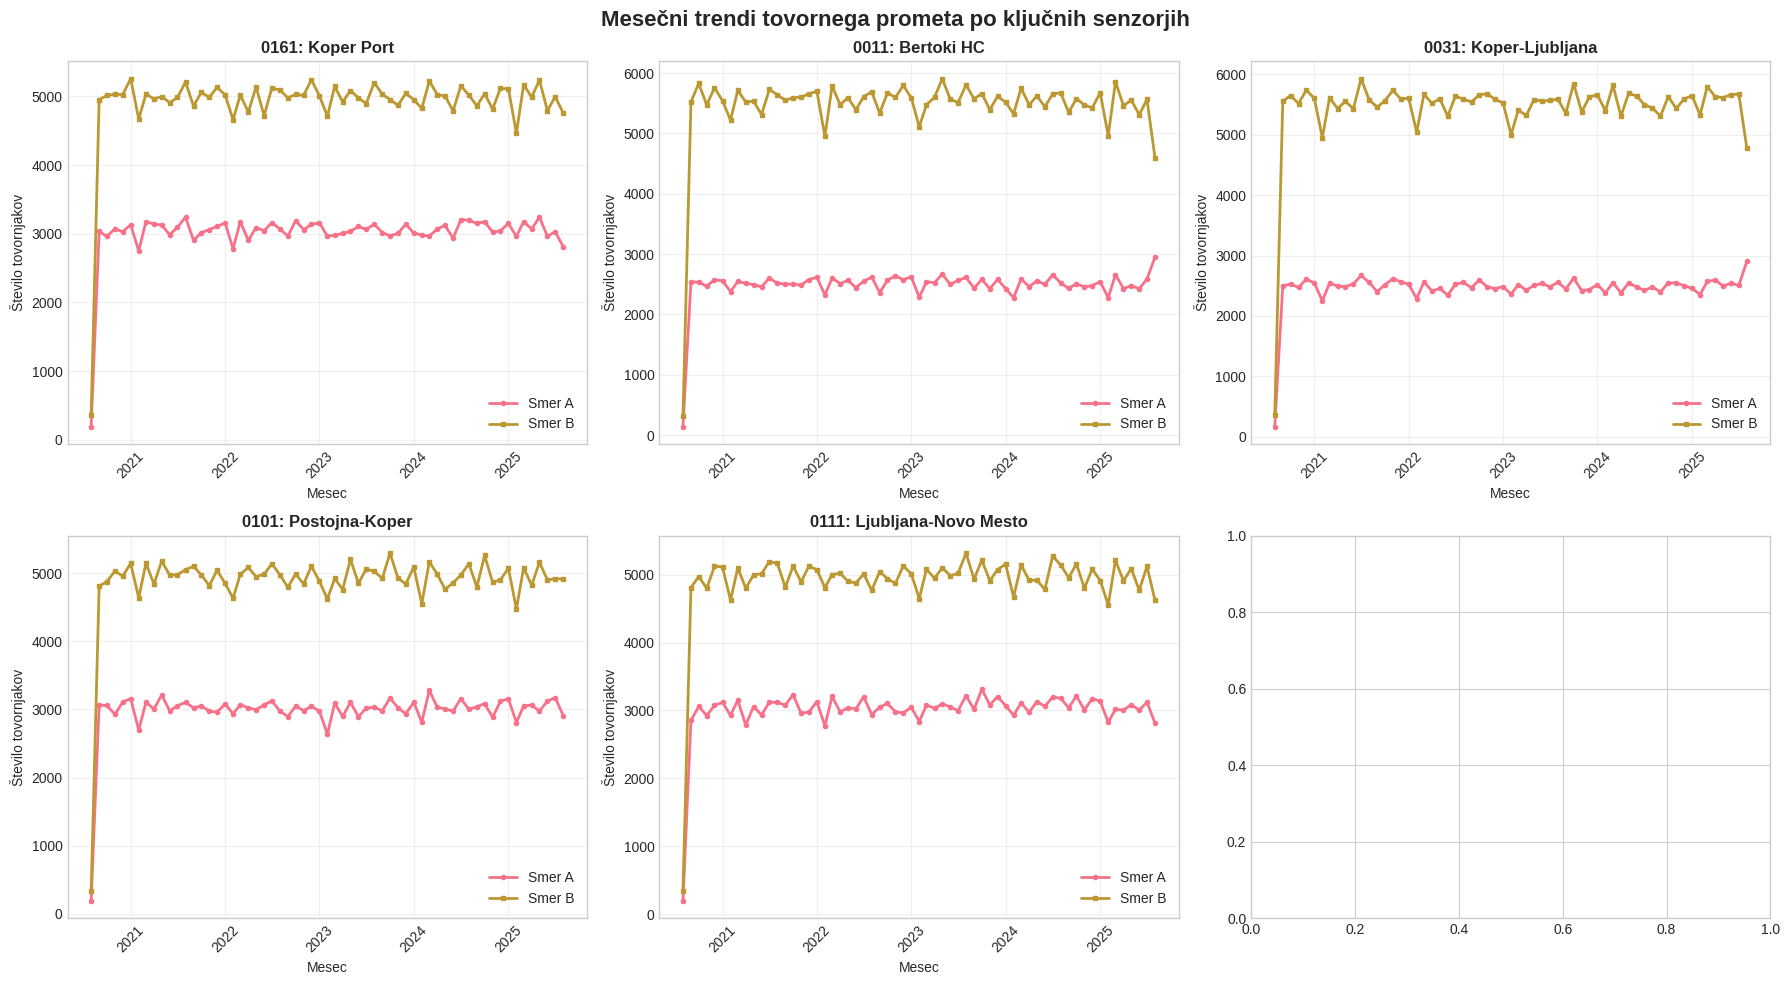

In [8]:
# Mesečni trendi za ključne senzorje
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Mesečni trendi tovornega prometa po ključnih senzorjih', fontsize=16, fontweight='bold')

for idx, sensor in enumerate(key_sensors[:6]):
    ax = axes[idx // 3, idx % 3]
    
    sensor_data = monthly_trucks[monthly_trucks['road_code'] == sensor]
    if len(sensor_data) > 0:
        road_name = sensor_data['road_name'].iloc[0]
        
        # Plot za obe smeri
        for direction in ['A', 'B']:
            dir_data = sensor_data[sensor_data['direction'] == direction].sort_values('year_month')
            if len(dir_data) > 0:
                ax.plot(
                    pd.to_datetime(dir_data['year_month'].astype(str)),
                    dir_data['trucks_count'],
                    label=f'Smer {direction}',
                    linewidth=2,
                    marker='o' if direction == 'A' else 's',
                    markersize=3
                )
        
        ax.set_title(f'{sensor}: {road_name}', fontweight='bold')
        ax.set_xlabel('Mesec')
        ax.set_ylabel('Število tovornjakov')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

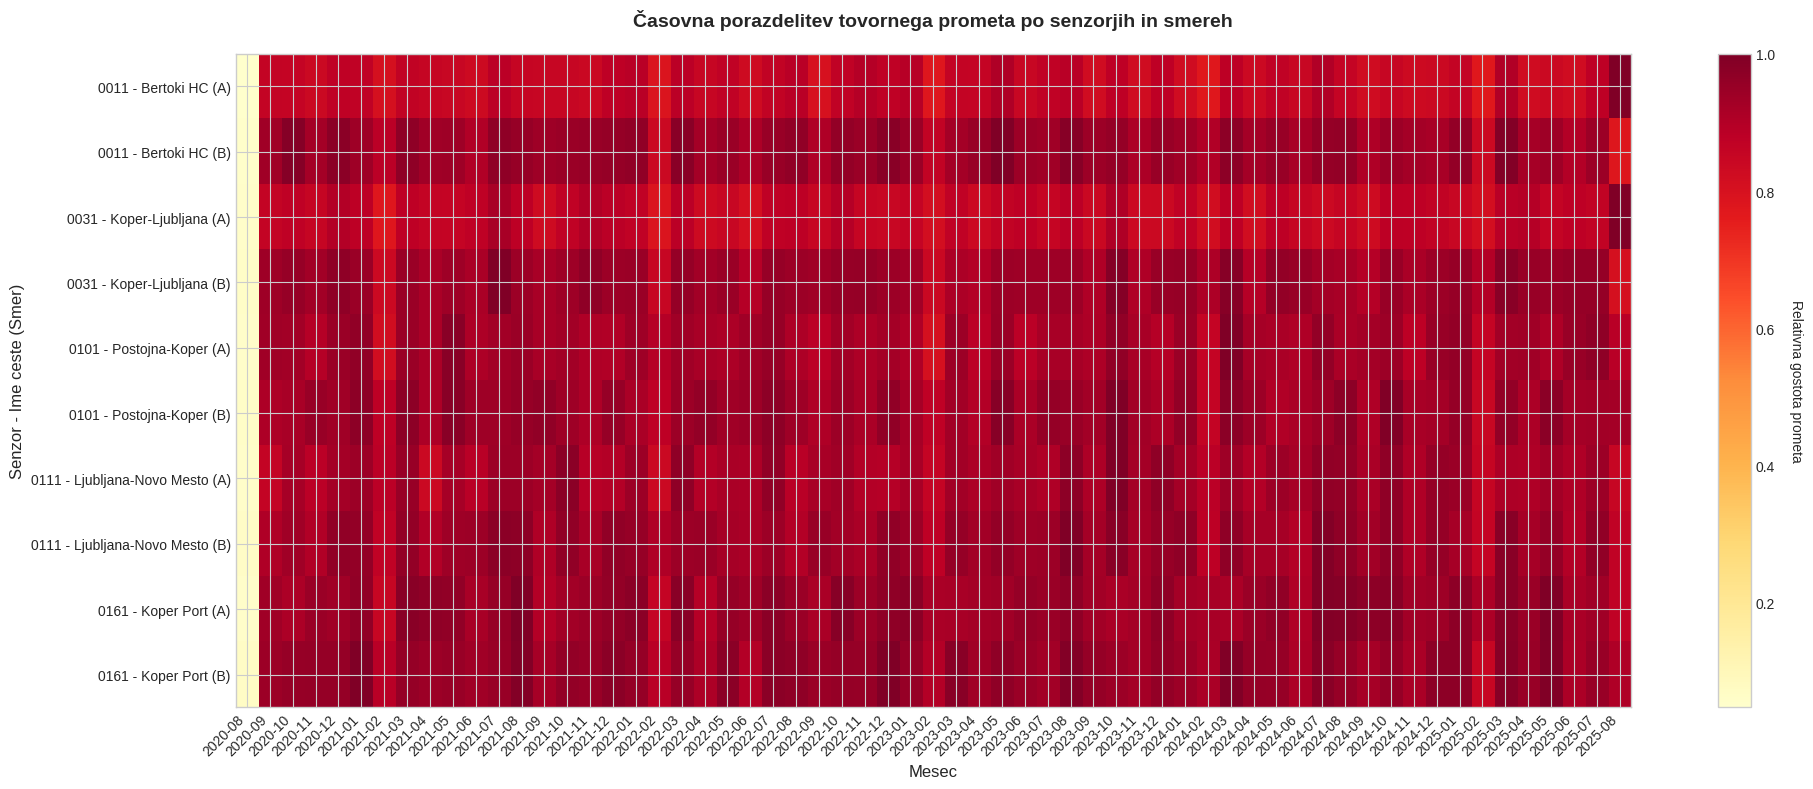

In [9]:
# Heatmap mesečnih trendov
# Priprava podatkov za heatmap
heatmap_data = monthly_trucks[monthly_trucks['road_code'].isin(key_sensors)].pivot_table(
    index=['road_code', 'road_name', 'direction'],
    columns='year_month',
    values='trucks_count',
    aggfunc='sum'
)

# Normalizacija po vrsticah (0-1)
heatmap_norm = heatmap_data.div(heatmap_data.max(axis=1), axis=0)

# Vizualizacija
fig, ax = plt.subplots(figsize=(20, 8))

# Pripravi labele
row_labels = [f"{code} - {name} ({dir})" 
              for code, name, dir in heatmap_norm.index]
col_labels = [str(col) for col in heatmap_norm.columns]

# Heatmap
im = ax.imshow(heatmap_norm.values, cmap='YlOrRd', aspect='auto')

# Nastavi osi
ax.set_xticks(np.arange(len(col_labels)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels, rotation=45, ha='right')
ax.set_yticklabels(row_labels)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Relativna gostota prometa', rotation=270, labelpad=20)

ax.set_title('Časovna porazdelitev tovornega prometa po senzorjih in smereh', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Mesec', fontsize=12)
ax.set_ylabel('Senzor - Ime ceste (Smer)', fontsize=12)

plt.tight_layout()
plt.show()

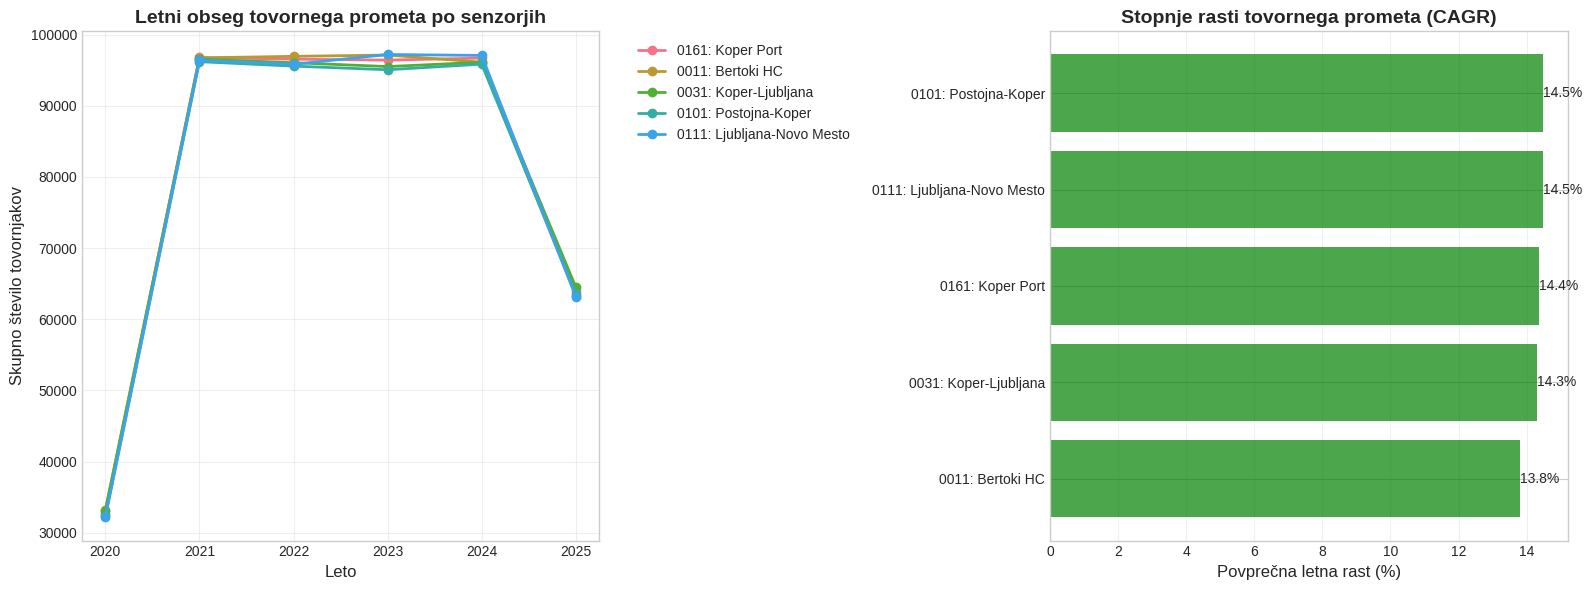

In [10]:
# Primerjava letne rasti po senzorjih
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Absolutne številke po letih
ax1 = axes[0]
yearly_total = yearly_stats[yearly_stats['road_code'].isin(key_sensors)].groupby(
    ['year', 'road_code', 'road_name']
)['trucks_count'].sum().reset_index()

for sensor in key_sensors:
    sensor_yearly = yearly_total[yearly_total['road_code'] == sensor]
    if len(sensor_yearly) > 0:
        road_name = sensor_yearly['road_name'].iloc[0]
        ax1.plot(sensor_yearly['year'], sensor_yearly['trucks_count'], 
                marker='o', linewidth=2, label=f'{sensor}: {road_name[:20]}')

ax1.set_xlabel('Leto', fontsize=12)
ax1.set_ylabel('Skupno število tovornjakov', fontsize=12)
ax1.set_title('Letni obseg tovornega prometa po senzorjih', fontsize=14, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Stopnje rasti
ax2 = axes[1]
growth_data = []

for sensor in key_sensors:
    sensor_yearly = yearly_total[yearly_total['road_code'] == sensor].sort_values('year')
    if len(sensor_yearly) > 1:
        years = sensor_yearly['year'].values
        values = sensor_yearly['trucks_count'].values
        
        # Izračun CAGR (Compound Annual Growth Rate)
        cagr = ((values[-1] / values[0]) ** (1/(len(values)-1)) - 1) * 100
        growth_data.append({
            'sensor': sensor,
            'name': sensor_yearly['road_name'].iloc[0][:20],
            'cagr': cagr
        })

if growth_data:
    growth_df = pd.DataFrame(growth_data).sort_values('cagr', ascending=True)
    colors = ['red' if x < 0 else 'green' for x in growth_df['cagr']]
    
    bars = ax2.barh(range(len(growth_df)), growth_df['cagr'], color=colors, alpha=0.7)
    ax2.set_yticks(range(len(growth_df)))
    ax2.set_yticklabels([f"{row['sensor']}: {row['name']}" for _, row in growth_df.iterrows()])
    ax2.set_xlabel('Povprečna letna rast (%)', fontsize=12)
    ax2.set_title('Stopnje rasti tovornega prometa (CAGR)', fontsize=14, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Dodaj vrednosti na palice
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax2.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', 
                ha='left' if width > 0 else 'right', 
                va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [11]:
# Interaktivni graf z Plotly
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Mesečni trendi tovornega prometa', 
                   'Letne stopnje rasti (%)'),
    vertical_spacing=0.15,
    row_heights=[0.7, 0.3]
)

# Barve za senzorje
colors = px.colors.qualitative.Set1

# 1. Mesečni trendi
for idx, sensor in enumerate(key_sensors):
    sensor_data = monthly_trucks[monthly_trucks['road_code'] == sensor]
    if len(sensor_data) > 0:
        road_name = sensor_data['road_name'].iloc[0]
        
        for direction in ['A', 'B']:
            dir_data = sensor_data[sensor_data['direction'] == direction].sort_values('year_month')
            if len(dir_data) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=pd.to_datetime(dir_data['year_month'].astype(str)),
                        y=dir_data['trucks_count'],
                        name=f'{sensor} {road_name[:15]} - Smer {direction}',
                        line=dict(color=colors[idx % len(colors)], 
                                 dash='solid' if direction == 'A' else 'dash'),
                        hovertemplate='<b>%{fullData.name}</b><br>' +
                                     'Mesec: %{x|%Y-%m}<br>' +
                                     'Tovornjaki: %{y:,.0f}<br>' +
                                     '<extra></extra>'
                    ),
                    row=1, col=1
                )

# 2. Letne stopnje rasti
growth_monthly = monthly_trucks[
    (monthly_trucks['road_code'].isin(key_sensors)) & 
    (monthly_trucks['yearly_growth_pct'].notna())
].groupby('year_month')['yearly_growth_pct'].mean().reset_index()

fig.add_trace(
    go.Bar(
        x=pd.to_datetime(growth_monthly['year_month'].astype(str)),
        y=growth_monthly['yearly_growth_pct'],
        name='Povprečna letna rast',
        marker_color=['red' if x < 0 else 'green' for x in growth_monthly['yearly_growth_pct']],
        hovertemplate='Mesec: %{x|%Y-%m}<br>' +
                     'Letna rast: %{y:.1f}%<br>' +
                     '<extra></extra>'
    ),
    row=2, col=1
)

# Posodobi osi
fig.update_xaxes(title_text="", row=1, col=1)
fig.update_xaxes(title_text="Mesec", row=2, col=1)
fig.update_yaxes(title_text="Število tovornjakov", row=1, col=1)
fig.update_yaxes(title_text="Rast (%)", row=2, col=1)

# Dodaj ničelno črto za stopnje rasti
fig.add_hline(y=0, line_dash="dash", line_color="gray", row=2, col=1)

fig.update_layout(
    height=800,
    title_text="Analiza trendov tovornega prometa po senzorjih",
    showlegend=True,
    hovermode='x unified'
)

fig.show()

## 5. Sezonska analiza

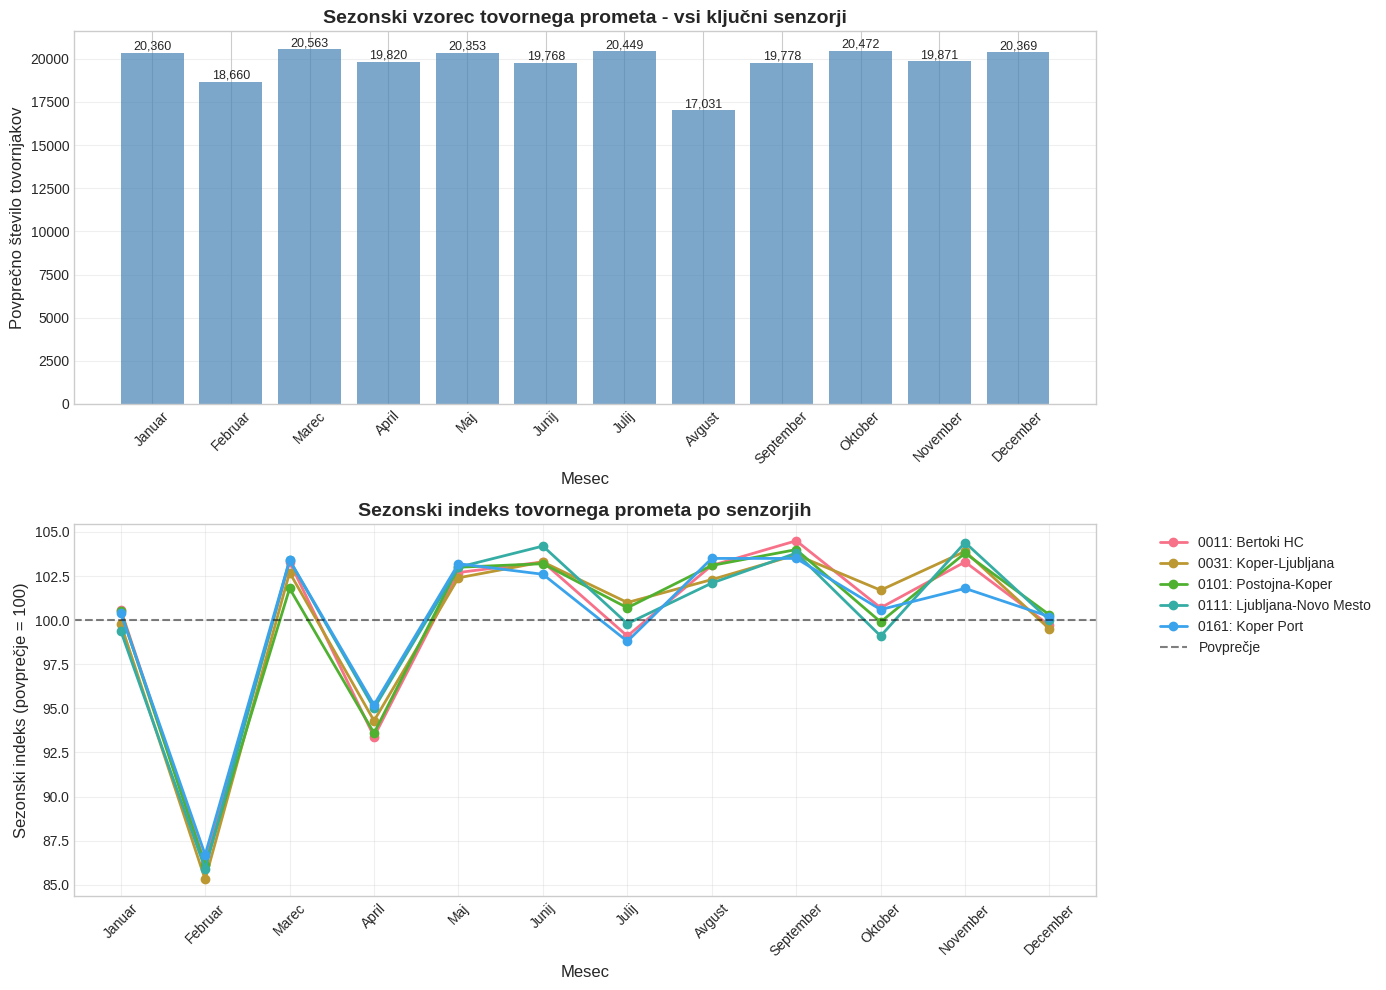


=== VRHUNSKI MESECI ZA TOVORNI PROMET ===
Marec: 20,563 tovornjakov (povprečno)
Oktober: 20,472 tovornjakov (povprečno)
Julij: 20,449 tovornjakov (povprečno)


In [12]:
# Sezonski vzorci po mesecih
seasonal_patterns = monthly_trucks[monthly_trucks['road_code'].isin(key_sensors)].groupby(
    ['month', 'mesec_slo', 'road_code', 'road_name']
)['trucks_count'].mean().reset_index()

# Vizualizacija sezonskih vzorcev
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. Skupni sezonski vzorec
ax1 = axes[0]
overall_seasonal = seasonal_patterns.groupby(['month', 'mesec_slo'])['trucks_count'].sum().reset_index()
bars = ax1.bar(overall_seasonal['month'], overall_seasonal['trucks_count'], 
              color='steelblue', alpha=0.7)

# Dodaj imena mesecev
ax1.set_xticks(overall_seasonal['month'])
ax1.set_xticklabels(overall_seasonal['mesec_slo'], rotation=45)
ax1.set_xlabel('Mesec', fontsize=12)
ax1.set_ylabel('Povprečno število tovornjakov', fontsize=12)
ax1.set_title('Sezonski vzorec tovornega prometa - vsi ključni senzorji', 
             fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Dodaj vrednosti na stolpce
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=9)

# 2. Sezonski indeks po senzorjih
ax2 = axes[1]
seasonal_index = seasonal_patterns.pivot_table(
    index='mesec_slo',
    columns='road_code',
    values='trucks_count',
    aggfunc='mean'
)

# Normalizacija na povprečje = 100
seasonal_index_norm = (seasonal_index / seasonal_index.mean() * 100).round(1)

# Line plot za vsak senzor
for col in seasonal_index_norm.columns:
    road_name = seasonal_patterns[seasonal_patterns['road_code'] == col]['road_name'].iloc[0]
    ax2.plot(range(1, 13), seasonal_index_norm[col].values, 
            marker='o', label=f'{col}: {road_name[:20]}', linewidth=2)

ax2.axhline(y=100, color='black', linestyle='--', alpha=0.5, label='Povprečje')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(overall_seasonal['mesec_slo'], rotation=45)
ax2.set_xlabel('Mesec', fontsize=12)
ax2.set_ylabel('Sezonski indeks (povprečje = 100)', fontsize=12)
ax2.set_title('Sezonski indeks tovornega prometa po senzorjih', 
             fontsize=14, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identifikacija vrhunskih mesecev
peak_months = overall_seasonal.nlargest(3, 'trucks_count')
print("\n=== VRHUNSKI MESECI ZA TOVORNI PROMET ===")
for _, row in peak_months.iterrows():
    print(f"{row['mesec_slo']}: {int(row['trucks_count']):,} tovornjakov (povprečno)")

## 6. Statistična analiza trendov

In [30]:
# Mann-Kendall test za trende
from scipy.stats import kendalltau

print("\n=== STATISTIČNA ANALIZA TRENDOV (Mann-Kendall test) ===")
print("="*70)

trend_results = []

for sensor in key_sensors:
    sensor_data = monthly_trucks[
        (monthly_trucks['road_code'] == sensor)
    ].groupby('year_month')['trucks_count'].sum().reset_index()
    
    if len(sensor_data) > 10:  # Potrebujemo dovolj podatkov
        # Kendall tau test
        x = np.arange(len(sensor_data))
        tau, p_value = kendalltau(x, sensor_data['trucks_count'])
        
        # Določi trend
        if p_value < 0.05:
            if tau > 0:
                trend = 'Naraščajoč'
            else:
                trend = 'Padajoč'
        else:
            trend = 'Ni značilnega trenda'
        
        road_name = monthly_trucks[monthly_trucks['road_code'] == sensor]['road_name'].iloc[0]
        
        trend_results.append({
            'Senzor': sensor,
            'Ime ceste': road_name,
            'Tau': round(tau, 3),
            'P-vrednost': round(p_value, 4),
            'Trend': trend
        })

trend_df = pd.DataFrame(trend_results)
print(tabulate(trend_df, headers='keys', tablefmt='grid', showindex=False))


=== STATISTIČNA ANALIZA TRENDOV (Mann-Kendall test) ===
+----------+----------------------+--------+--------------+----------------------+
|   Senzor | Ime ceste            |    Tau |   P-vrednost | Trend                |
+==========+======================+========+==============+======================+
|     0161 | Koper Port           |  0.025 |       0.7794 | Ni značilnega trenda |
+----------+----------------------+--------+--------------+----------------------+
|     0011 | Bertoki HC           | -0.093 |       0.2901 | Ni značilnega trenda |
+----------+----------------------+--------+--------------+----------------------+
|     0031 | Koper-Ljubljana      |  0.023 |       0.7938 | Ni značilnega trenda |
+----------+----------------------+--------+--------------+----------------------+
|     0101 | Postojna-Koper       |  0.029 |       0.7415 | Ni značilnega trenda |
+----------+----------------------+--------+--------------+----------------------+
|     0111 | Ljubljana-Novo Me

In [14]:
# Primerjava pred in po COVID (2020-2021 vs 2022-2025)
print("\n=== ANALIZA VPLIVA COVID-19 NA TOVORNI PROMET ===")
print("="*70)

covid_period = monthly_trucks[monthly_trucks['year'].isin([2020, 2021])]
post_covid = monthly_trucks[monthly_trucks['year'].isin([2022, 2023, 2024, 2025])]

covid_analysis = []

for sensor in key_sensors:
    covid_sensor = covid_period[covid_period['road_code'] == sensor]['trucks_count'].sum()
    post_sensor = post_covid[post_covid['road_code'] == sensor]['trucks_count'].sum()
    
    # Normaliziraj po številu mesecev
    covid_months = len(covid_period[covid_period['road_code'] == sensor]['year_month'].unique())
    post_months = len(post_covid[post_covid['road_code'] == sensor]['year_month'].unique())
    
    if covid_months > 0 and post_months > 0:
        covid_avg = covid_sensor / covid_months
        post_avg = post_sensor / post_months
        change_pct = ((post_avg - covid_avg) / covid_avg * 100) if covid_avg > 0 else 0
        
        road_name = monthly_trucks[monthly_trucks['road_code'] == sensor]['road_name'].iloc[0]
        
        covid_analysis.append({
            'Senzor': sensor,
            'Ime ceste': road_name[:30],
            'COVID povprečje': int(covid_avg),
            'Po-COVID povprečje': int(post_avg),
            'Sprememba (%)': round(change_pct, 1)
        })

covid_df = pd.DataFrame(covid_analysis)
covid_df = covid_df.sort_values('Sprememba (%)', ascending=False)
print(tabulate(covid_df, headers='keys', tablefmt='grid', showindex=False))


=== ANALIZA VPLIVA COVID-19 NA TOVORNI PROMET ===
+----------+----------------------+-------------------+----------------------+-----------------+
|   Senzor | Ime ceste            |   COVID povprečje |   Po-COVID povprečje |   Sprememba (%) |
+==========+======================+===================+======================+=================+
|     0111 | Ljubljana-Novo Mesto |              7563 |                 8030 |             6.2 |
+----------+----------------------+-------------------+----------------------+-----------------+
|     0161 | Koper Port           |              7616 |                 8037 |             5.5 |
+----------+----------------------+-------------------+----------------------+-----------------+
|     0011 | Bertoki HC           |              7640 |                 8035 |             5.2 |
+----------+----------------------+-------------------+----------------------+-----------------+
|     0101 | Postojna-Koper       |              7562 |                 7957

In [31]:
# KOREKTNA Primerjava 2024 vs 2025 (Januar-Avgust)
print("\n=== KOREKTNA PRIMERJAVA TOVORNEGA PROMETA 2024 vs 2025 (Jan-Avg) ===")
print("POMEMBNO: Primerjava PO SENZORJIH (brez dvojnega štetja tovornjakov)")
print("="*80)

# Filtriranje podatkov za pošteno primerjavo: samo Januar-Avgust za oba leta
data_2024_jan_aug = monthly_trucks[
    (monthly_trucks['year'] == 2024) & 
    (monthly_trucks['month'].isin([1, 2, 3, 4, 5, 6, 7, 8]))
]
data_2025_jan_aug = monthly_trucks[
    (monthly_trucks['year'] == 2025) & 
    (monthly_trucks['month'].isin([1, 2, 3, 4, 5, 6, 7, 8]))
]

comparison_corrected = []

for sensor in key_sensors:
    for direction in ['A', 'B']:
        # Podatki za 2024 (Jan-Avg)
        trucks_2024_period = data_2024_jan_aug[
            (data_2024_jan_aug['road_code'] == sensor) & 
            (data_2024_jan_aug['direction'] == direction)
        ]['trucks_count'].sum()
        
        # Podatki za 2025 (Jan-Avg)
        trucks_2025_period = data_2025_jan_aug[
            (data_2025_jan_aug['road_code'] == sensor) & 
            (data_2025_jan_aug['direction'] == direction)
        ]['trucks_count'].sum()
        
        # Mesečni povprečji
        months_available = 8  # Januar do Avgust
        avg_2024 = trucks_2024_period / months_available
        avg_2025 = trucks_2025_period / months_available
        
        # Sprememba v %
        change_pct = ((avg_2025 - avg_2024) / avg_2024 * 100) if avg_2024 > 0 else 0
        
        if trucks_2024_period > 0 or trucks_2025_period > 0:  # Samo če imamo podatke
            road_name = monthly_trucks[monthly_trucks['road_code'] == sensor]['road_name'].iloc[0]
            
            comparison_corrected.append({
                'Senzor': sensor,
                'Smer': direction,
                'Ime ceste': road_name[:25],
                'Skupaj 2024 (Jan-Avg)': int(trucks_2024_period),
                'Skupaj 2025 (Jan-Avg)': int(trucks_2025_period),
                'Mesečno 2024': int(avg_2024),
                'Mesečno 2025': int(avg_2025),
                'Sprememba (%)': round(change_pct, 1)
            })

comparison_corrected_df = pd.DataFrame(comparison_corrected)
comparison_corrected_df = comparison_corrected_df.sort_values('Sprememba (%)', ascending=False)

print(tabulate(comparison_corrected_df, headers='keys', tablefmt='grid', showindex=False))

# Povzetek sprememb
print(f"\nPOVZETEK SPREMEMB 2024 vs 2025 (Jan-Avg, po senzor-smereh):")
print(f"• Povprečna sprememba: {comparison_corrected_df['Sprememba (%)'].mean():.1f}%")
print(f"• Senzor-smeri z rastjo: {len(comparison_corrected_df[comparison_corrected_df['Sprememba (%)'] > 0])}")
print(f"• Senzor-smeri s padcem: {len(comparison_corrected_df[comparison_corrected_df['Sprememba (%)'] < 0])}")
print(f"• Največja rast: {comparison_corrected_df.iloc[0]['Senzor']}-{comparison_corrected_df.iloc[0]['Smer']} ({comparison_corrected_df.iloc[0]['Sprememba (%)']:.1f}%)")
print(f"• Največji padec: {comparison_corrected_df.iloc[-1]['Senzor']}-{comparison_corrected_df.iloc[-1]['Smer']} ({comparison_corrected_df.iloc[-1]['Sprememba (%)']:.1f}%)")

# Analiza po senzorjih (povprečje obeh smeri)
sensor_analysis = comparison_corrected_df.groupby(['Senzor', 'Ime ceste']).agg({
    'Skupaj 2024 (Jan-Avg)': 'sum',
    'Skupaj 2025 (Jan-Avg)': 'sum',
    'Sprememba (%)': 'mean'
}).reset_index()
sensor_analysis = sensor_analysis.sort_values('Sprememba (%)', ascending=False)

print(f"\n=== ANALIZA PO SENZORJIH (obe smeri skupaj) ===")
print(tabulate(sensor_analysis, headers='keys', tablefmt='grid', showindex=False))


=== KOREKTNA PRIMERJAVA TOVORNEGA PROMETA 2024 vs 2025 (Jan-Avg) ===
POMEMBNO: Primerjava PO SENZORJIH (brez dvojnega štetja tovornjakov)
+----------+--------+----------------------+-------------------------+-------------------------+----------------+----------------+-----------------+
|   Senzor | Smer   | Ime ceste            |   Skupaj 2024 (Jan-Avg) |   Skupaj 2025 (Jan-Avg) |   Mesečno 2024 |   Mesečno 2025 |   Sprememba (%) |
+==========+========+======================+=========================+=========================+================+================+=================+
|     0031 | A      | Koper-Ljubljana      |                   19760 |                   20422 |           2470 |           2552 |             3.4 |
+----------+--------+----------------------+-------------------------+-------------------------+----------------+----------------+-----------------+
|     0011 | A      | Bertoki HC           |                   19992 |                   20346 |           2499 |   

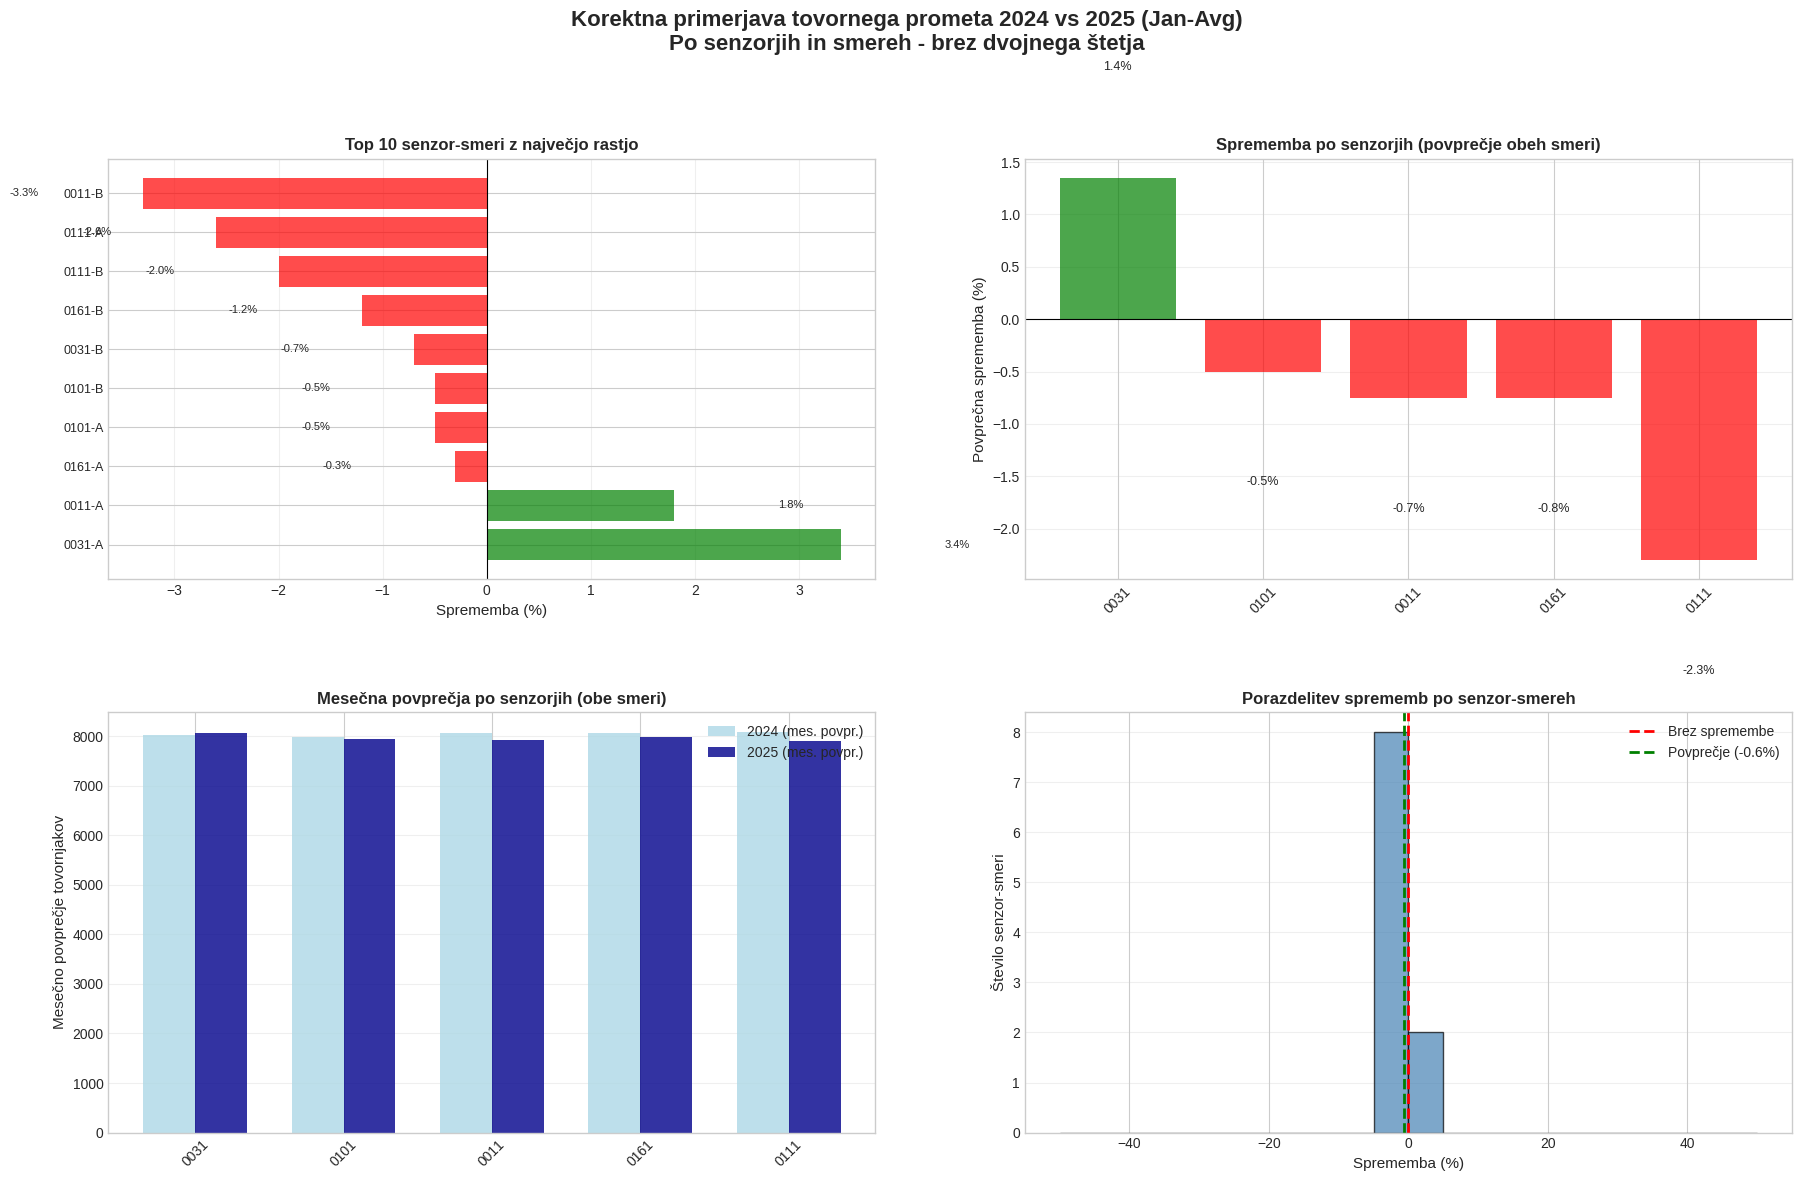


=== STATISTIKE SPREMEMB ===
Mediana spremembe: -0.6%
Standardni odklon: 2.0%
75% senzor-smeri ima spremembo med -1.8% in -0.3%


In [32]:
# Vizualizacija KOREKTNE primerjave 2024 vs 2025 (Jan-Avg)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Korektna primerjava tovornega prometa 2024 vs 2025 (Jan-Avg)\nPo senzorjih in smereh - brez dvojnega štetja', 
             fontsize=16, fontweight='bold')

# 1. Top 10 senzor-smeri z največjo rastjo
ax1 = axes[0, 0]
top_growth = comparison_corrected_df.head(10)
y_pos = np.arange(len(top_growth))
colors_growth = ['green' if x > 0 else 'red' for x in top_growth['Sprememba (%)']]

bars1 = ax1.barh(y_pos, top_growth['Sprememba (%)'], color=colors_growth, alpha=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels([f"{row['Senzor']}-{row['Smer']}" for _, row in top_growth.iterrows()], fontsize=9)
ax1.set_xlabel('Sprememba (%)', fontsize=11)
ax1.set_title('Top 10 senzor-smeri z največjo rastjo', fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax1.grid(True, alpha=0.3, axis='x')

# Dodaj vrednosti na palice
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + (1 if width > 0 else -1), bar.get_y() + bar.get_height()/2, 
            f'{width:.1f}%', ha='left' if width > 0 else 'right', va='center', fontsize=8)

# 2. Primerjava po senzorjih (povprečje obeh smeri)
ax2 = axes[0, 1]
x_pos = np.arange(len(sensor_analysis))
colors_sensor = ['green' if x > 0 else 'red' for x in sensor_analysis['Sprememba (%)']]

bars2 = ax2.bar(x_pos, sensor_analysis['Sprememba (%)'], color=colors_sensor, alpha=0.7)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(sensor_analysis['Senzor'], rotation=45, fontsize=10)
ax2.set_ylabel('Povprečna sprememba (%)', fontsize=11)
ax2.set_title('Sprememba po senzorjih (povprečje obeh smeri)', fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(True, alpha=0.3, axis='y')

# Dodaj vrednosti na stolpce
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -1),
            f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

# 3. Absolutne številke - primerjava mesečnih povprečij
ax3 = axes[1, 0]
x_pos = np.arange(len(sensor_analysis))
width = 0.35

bars3a = ax3.bar(x_pos - width/2, sensor_analysis['Skupaj 2024 (Jan-Avg)'] / 8, 
                width, label='2024 (mes. povpr.)', color='lightblue', alpha=0.8)
bars3b = ax3.bar(x_pos + width/2, sensor_analysis['Skupaj 2025 (Jan-Avg)'] / 8, 
                width, label='2025 (mes. povpr.)', color='darkblue', alpha=0.8)

ax3.set_xticks(x_pos)
ax3.set_xticklabels(sensor_analysis['Senzor'], rotation=45, fontsize=10)
ax3.set_ylabel('Mesečno povprečje tovornjakov', fontsize=11)
ax3.set_title('Mesečna povprečja po senzorjih (obe smeri)', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Porazdelitev sprememb
ax4 = axes[1, 1]
changes = comparison_corrected_df['Sprememba (%)']
bins = np.arange(-50, 51, 5)
ax4.hist(changes, bins=bins, color='steelblue', alpha=0.7, edgecolor='black')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Brez spremembe')
ax4.axvline(x=changes.mean(), color='green', linestyle='--', linewidth=2, 
           label=f'Povprečje ({changes.mean():.1f}%)')
ax4.set_xlabel('Sprememba (%)', fontsize=11)
ax4.set_ylabel('Število senzor-smeri', fontsize=11)
ax4.set_title('Porazdelitev sprememb po senzor-smereh', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Dodatne statistike
print(f"\n=== STATISTIKE SPREMEMB ===")
print(f"Mediana spremembe: {changes.median():.1f}%")
print(f"Standardni odklon: {changes.std():.1f}%")
print(f"75% senzor-smeri ima spremembo med {changes.quantile(0.25):.1f}% in {changes.quantile(0.75):.1f}%")


=== MESEČNA PRIMERJAVA 2024 vs 2025 ===
+-----------+---------------+---------------+-----------------+
| Mesec     |   Skupaj 2024 | Skupaj 2025   | Sprememba (%)   |
+===========+===============+===============+=================+
| Januar    |        163506 | 163435        | -0.0            |
+-----------+---------------+---------------+-----------------+
| Februar   |        153297 | 148097        | -3.4            |
+-----------+---------------+---------------+-----------------+
| Marec     |        164219 | 163946        | -0.2            |
+-----------+---------------+---------------+-----------------+
| April     |        158794 | 157594        | -0.8            |
+-----------+---------------+---------------+-----------------+
| Maj       |        163082 | 162184        | -0.6            |
+-----------+---------------+---------------+-----------------+
| Junij     |        157655 | 159776        | 1.3             |
+-----------+---------------+---------------+-----------------+

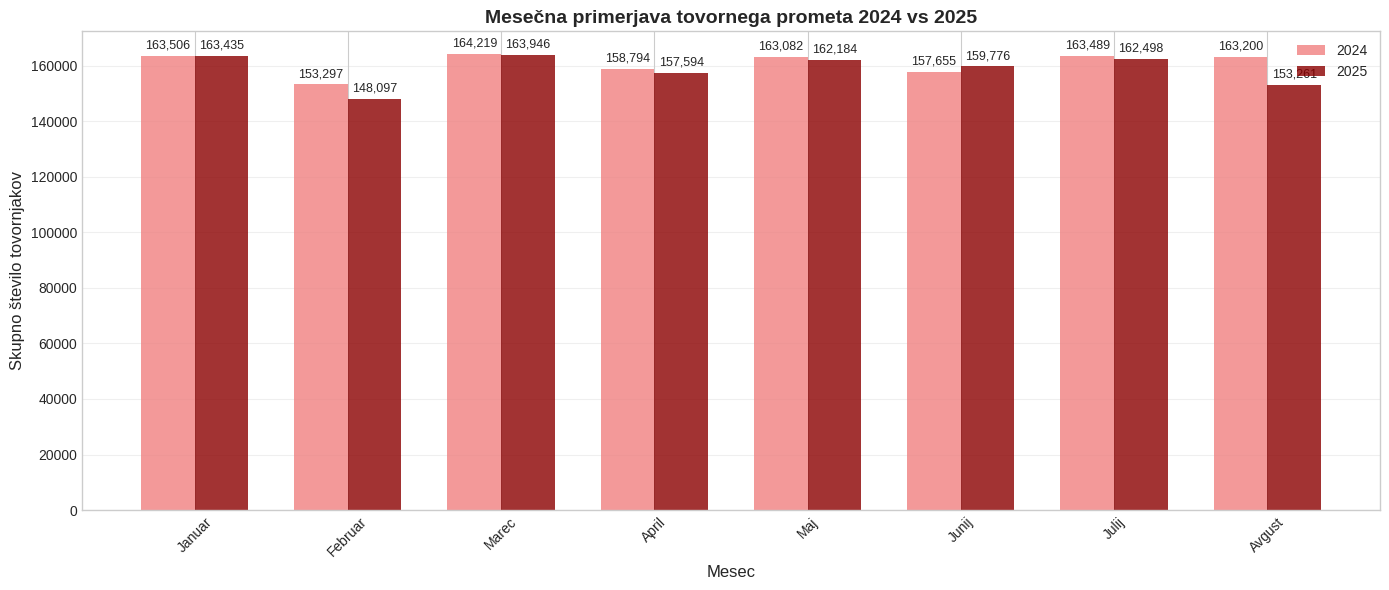


Povprečna mesečna sprememba (razpoložljivi meseci): -1.3%


In [33]:
# Mesečna primerjava 2024 vs 2025
print("\n=== MESEČNA PRIMERJAVA 2024 vs 2025 ===")

# Priprava mesečnih podatkov za primerjavo
monthly_comparison = []

for month in range(1, 13):
    month_name = SLOVENSKI_MESECI[month]
    
    # Podatki za 2024
    trucks_2024_month = data_2024[data_2024['month'] == month]['trucks_count'].sum()
    
    # Podatki za 2025 (samo če je mesec že prešel ali je trenutni)
    trucks_2025_month = data_2025[data_2025['month'] == month]['trucks_count'].sum()
    
    # Če imamo podatke za oba leta
    if trucks_2024_month > 0:
        if trucks_2025_month > 0:
            change_pct = ((trucks_2025_month - trucks_2024_month) / trucks_2024_month * 100)
            status = "Podatki za oba leta"
        else:
            change_pct = None
            status = "Ni podatkov za 2025"
    else:
        change_pct = None
        status = "Ni podatkov za 2024"
    
    monthly_comparison.append({
        'Mesec': month_name,
        'Mesec_št': month,
        '2024': int(trucks_2024_month) if trucks_2024_month > 0 else '-',
        '2025': int(trucks_2025_month) if trucks_2025_month > 0 else '-',
        'Sprememba (%)': round(change_pct, 1) if change_pct is not None else '-',
        'Status': status
    })

monthly_comp_df = pd.DataFrame(monthly_comparison)
print(tabulate(monthly_comp_df[['Mesec', '2024', '2025', 'Sprememba (%)']], 
               headers=['Mesec', 'Skupaj 2024', 'Skupaj 2025', 'Sprememba (%)'], 
               tablefmt='grid', showindex=False))

# Vizualizacija mesečne primerjave
fig, ax = plt.subplots(figsize=(14, 6))

# Filtriraj mesece z veljavnimi podatki za oba leta
valid_months = monthly_comp_df[
    (monthly_comp_df['2024'] != '-') & 
    (monthly_comp_df['2025'] != '-')
].copy()

if len(valid_months) > 0:
    x_pos = np.arange(len(valid_months))
    width = 0.35
    
    values_2024 = [int(x) for x in valid_months['2024']]
    values_2025 = [int(x) for x in valid_months['2025']]
    
    bars1 = ax.bar(x_pos - width/2, values_2024, width, 
                   label='2024', color='lightcoral', alpha=0.8)
    bars2 = ax.bar(x_pos + width/2, values_2025, width, 
                   label='2025', color='darkred', alpha=0.8)
    
    ax.set_xlabel('Mesec', fontsize=12)
    ax.set_ylabel('Skupno število tovornjakov', fontsize=12)
    ax.set_title('Mesečna primerjava tovornega prometa 2024 vs 2025', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(valid_months['Mesec'], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Dodaj vrednosti na stolpce
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        ax.text(bar1.get_x() + bar1.get_width()/2., height1 + height1*0.01,
                f'{int(height1):,}', ha='center', va='bottom', fontsize=9)
        ax.text(bar2.get_x() + bar2.get_width()/2., height2 + height2*0.01,
                f'{int(height2):,}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Statistični povzetek
    avg_change = valid_months['Sprememba (%)'].replace('-', np.nan).dropna().astype(float).mean()
    print(f"\nPovprečna mesečna sprememba (razpoložljivi meseci): {avg_change:.1f}%")
else:
    print("Ni dovolj podatkov za vizualizacijo mesečne primerjave.")

## 7. Izvoz rezultatov

In [15]:
# Izvoz glavne tabele
output_file = '../data/processed/truck_trends_by_sensor.csv'
main_table.to_csv(output_file, index=False, encoding='utf-8')
print(f"Glavna tabela shranjena v: {output_file}")

# Izvoz letnih statistik
yearly_file = '../data/processed/truck_trends_yearly_stats.csv'
yearly_pivot.to_csv(yearly_file, encoding='utf-8')
print(f"Letne statistike shranjene v: {yearly_file}")

# Izvoz sezonskih vzorcev
seasonal_file = '../data/processed/truck_seasonal_patterns.csv'
seasonal_patterns.to_csv(seasonal_file, index=False, encoding='utf-8')
print(f"Sezonski vzorci shranjeni v: {seasonal_file}")

Glavna tabela shranjena v: ../data/processed/truck_trends_by_sensor.csv
Letne statistike shranjene v: ../data/processed/truck_trends_yearly_stats.csv
Sezonski vzorci shranjeni v: ../data/processed/truck_seasonal_patterns.csv


## 8. Povzetek ključnih ugotovitev

In [16]:
print("\n" + "="*70)
print("POVZETEK ANALIZE TRENDOV TOVORNEGA PROMETA")
print("="*70)

# Najhitreje rastoči senzorji
growth_summary = []
for sensor in key_sensors:
    sensor_yearly = yearly_stats[
        (yearly_stats['road_code'] == sensor)
    ].groupby('year')['trucks_count'].sum().reset_index()
    
    if len(sensor_yearly) > 1:
        values = sensor_yearly['trucks_count'].values
        years = sensor_yearly['year'].values
        cagr = ((values[-1] / values[0]) ** (1/(len(values)-1)) - 1) * 100
        
        road_name = monthly_trucks[monthly_trucks['road_code'] == sensor]['road_name'].iloc[0]
        growth_summary.append({
            'sensor': sensor,
            'name': road_name,
            'cagr': cagr,
            'total_2025': values[-1] if len(values) > 0 else 0
        })

growth_df = pd.DataFrame(growth_summary).sort_values('cagr', ascending=False)

print("\n1. NAJHITREJE RASTOČI SENZORJI:")
for i, row in growth_df.head(3).iterrows():
    print(f"   • {row['sensor']} ({row['name']}): {row['cagr']:.1f}% letna rast")

print("\n2. SENZORJI Z NAJVEČJIM OBSEGOM (2025):")
volume_df = growth_df.sort_values('total_2025', ascending=False)
for i, row in volume_df.head(3).iterrows():
    print(f"   • {row['sensor']} ({row['name']}): {int(row['total_2025']):,} tovornjakov")

print("\n3. SEZONSKI VZORCI:")
peak_months_list = overall_seasonal.nlargest(3, 'trucks_count')['mesec_slo'].tolist()
low_months_list = overall_seasonal.nsmallest(3, 'trucks_count')['mesec_slo'].tolist()
print(f"   • Vrhunski meseci: {', '.join(peak_months_list)}")
print(f"   • Najnižji promet: {', '.join(low_months_list)}")

print("\n4. STATISTIČNA ZNAČILNOST TRENDOV:")
significant_trends = trend_df[trend_df['P-vrednost'] < 0.05]
print(f"   • Senzorji s statistično značilnim trendom: {len(significant_trends)}/{len(trend_df)}")
print(f"   • Naraščajoči trendi: {len(significant_trends[significant_trends['Trend'] == 'Naraščajoč'])}")
print(f"   • Padajoči trendi: {len(significant_trends[significant_trends['Trend'] == 'Padajoč'])}")

print("\n5. VPLIV COVID-19:")
avg_covid_impact = covid_df['Sprememba (%)'].mean()
print(f"   • Povprečna sprememba po COVID: {avg_covid_impact:.1f}%")
max_increase = covid_df.iloc[0]
print(f"   • Največja rast: {max_increase['Senzor']} ({max_increase['Sprememba (%)']:.1f}%)")

print("\n" + "="*70)


POVZETEK ANALIZE TRENDOV TOVORNEGA PROMETA

1. NAJHITREJE RASTOČI SENZORJI:
   • 0101 (Postojna-Koper): 14.5% letna rast
   • 0111 (Ljubljana-Novo Mesto): 14.5% letna rast
   • 0161 (Koper Port): 14.4% letna rast

2. SENZORJI Z NAJVEČJIM OBSEGOM (2025):
   • 0031 (Koper-Ljubljana): 64,529 tovornjakov
   • 0161 (Koper Port): 63,927 tovornjakov
   • 0101 (Postojna-Koper): 63,606 tovornjakov

3. SEZONSKI VZORCI:
   • Vrhunski meseci: Marec, Oktober, Julij
   • Najnižji promet: Avgust, Februar, Junij

4. STATISTIČNA ZNAČILNOST TRENDOV:
   • Senzorji s statistično značilnim trendom: 0/5
   • Naraščajoči trendi: 0
   • Padajoči trendi: 0

5. VPLIV COVID-19:
   • Povprečna sprememba po COVID: 5.4%
   • Največja rast: 0111 (6.2%)



In [21]:
# Preverimo razpoložljivost podatkov
print("=== RAZPOLOŽLJIVOST PODATKOV ===")
print(f"Celotno obdobje: {df['datetime'].min()} do {df['datetime'].max()}")
print(f"Podatki za 2024: {df[df['year'] == 2024]['datetime'].min()} do {df[df['year'] == 2024]['datetime'].max()}")
print(f"Podatki za 2025: {df[df['year'] == 2025]['datetime'].min()} do {df[df['year'] == 2025]['datetime'].max()}")

# Preverimo mesečno pokritost
print("\nMesečna pokritost po letih:")
coverage_by_year = df.groupby(['year', 'month']).size().reset_index(name='records')
coverage_pivot = coverage_by_year.pivot(index='month', columns='year', values='records').fillna(0)
print(coverage_pivot[[2024, 2025]])

=== RAZPOLOŽLJIVOST PODATKOV ===
Celotno obdobje: 2020-08-30 00:00:00 do 2025-08-29 23:00:00
Podatki za 2024: 2024-01-01 00:00:00 do 2024-12-31 23:00:00
Podatki za 2025: 2025-01-01 00:00:00 do 2025-08-29 23:00:00

Mesečna pokritost po letih:
year      2024     2025
month                  
1      14880.0  14880.0
2      13920.0  13440.0
3      14880.0  14880.0
4      14400.0  14400.0
5      14880.0  14880.0
6      14400.0  14400.0
7      14880.0  14880.0
8      14880.0  13920.0
9      14400.0      0.0
10     14880.0      0.0
11     14400.0      0.0
12     14880.0      0.0
